# Multivariate LSTM prediction
https://github.com/raiak82/LongShortMemorymodelNifty/blob/master/Nifty-Model.ipynb

https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## 1. Import Libraries

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import math, re
import datetime as dt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import seaborn as sns
%matplotlib inline

#LSTM RNN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, utils
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras import backend as K



Using TensorFlow backend.


In [2]:
# import asset data: open, close, volume
%store -r data_EMB
%store -r vol_EMB

In [3]:
#import TECHNICAL data
%store -r data_vix

# MULTIVARIATE LSTM - Single asset (in-sample) prediction
## Use Adj Close Price, Open Price, Volume, Savings Rate, and VIX to engineer the features

In [4]:
EMB_all = pd.concat([data_EMB, vol_EMB, data_vix],axis=1).dropna()
EMB_all.columns = ['Adj_Close','Volume','VIX']

### Data info and visualize

In [5]:
EMB_all.head(3)

,Adj_Close,Volume,VIX
Date,,,
2009-06-01,57.978580,237000.0,30.040001
2009-06-08,57.947876,274200.0,29.770000
2009-06-15,57.216545,234000.0,30.809999


In [6]:
EMB_all.tail(2)

,Adj_Close,Volume,VIX
Date,,,
2019-05-13,107.687950,27522700.0,20.549999
2019-05-20,108.201881,16430700.0,16.309999


In [7]:
EMB_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 472 entries, 2009-06-01 to 2019-05-20
Data columns (total 3 columns):
Adj_Close    472 non-null float32
Volume       472 non-null float32
VIX          472 non-null float32
dtypes: float32(3)
memory usage: 9.2 KB


In [8]:
EMB_all.dtypes

Adj_Close    float32
Volume       float32
VIX          float32
dtype: object

In [9]:
EMB_all.shape

(472, 3)

In [10]:
EMB_all.describe()

,Adj_Close,Volume,VIX
count,472.000000,472.0,472.000000
mean,86.821945,6513792.0,17.575914
std,13.023093,6680014.5,6.121978
min,57.216545,144800.0,9.340000
25%,76.286175,1955200.0,13.272500
50%,88.592926,3876200.0,15.975000
75%,99.472500,9282750.0,20.055001
max,108.201881,36674600.0,48.000000


In [11]:
EMB_all.columns

Index(['Adj_Close', 'Volume', 'VIX'], dtype='object')

In [12]:
EMB_all.columns.get_loc("Adj_Close")

0

In [13]:
#sanity checks
EMB_all.isnull().sum()

Adj_Close    0
Volume       0
VIX          0
dtype: int64

In [14]:
data_pct = EMB_all.pct_change()

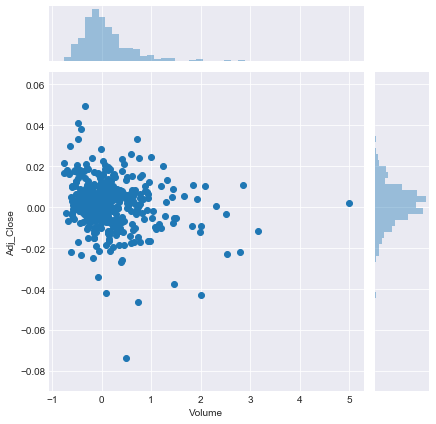

In [15]:
## Corr between volume and closing price
sns.jointplot(x='Volume', y='Adj_Close', data=data_pct)  
plt.show()

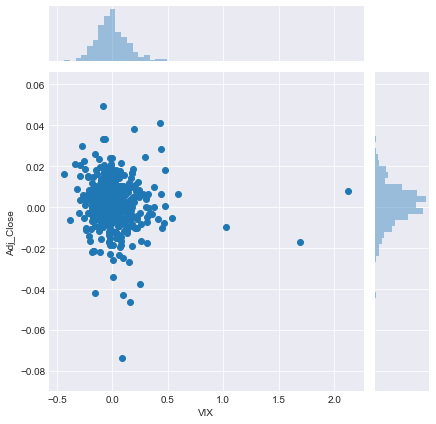

In [16]:
## Corr between volume and closing price
sns.jointplot(x='VIX', y='Adj_Close', data=data_pct)  
plt.show()

### Model helper functions
Predict closing price at t given closing price + other features at previous timesteps
* Convert time series to SUPERVISED LEARNING
* Using one lag observation as input (x)
* Using one observation as output (y)

In [17]:
# function to shift left and shift forward the time series dataframe where n_in paramter 
# used to shift left and n_out parameter used to shift right
def series_to_new_supervised(df, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    #names = df.columns.values
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(' %s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(' %s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [(' %s(t+%d)' % (df.columns[j], i))for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    else:
        agg = agg.fillna(0)
    return agg

In [18]:
#Columns to be removed from the transformed series. For example - after time series is shifted to N+1, you may want only-
#columns in shifted time series i.e you may want only adj_close rest other columns can be droped from N+1
def remove_columns_from_transformed_series(df2, main_column, negative, positive):
    columns_to_be_removed=[]
    for i in range(0,df2.shape[1]):
        string1=df2.columns[i]
        if re.search("\(t\-",string1): 
            if not (re.search(main_column,string1)):
                if (negative==1):
                    columns_to_be_removed.append(string1)
        if re.search("\(t\+",string1):
            if not (re.search(main_column,string1)):
                if (positive==1):
                    columns_to_be_removed.append(string1)
    df2.drop(columns_to_be_removed, axis=1, inplace=True)
    return df2

In [19]:
#shift series to obtain t+1 for Y column
shiftRightSeries=series_to_new_supervised(EMB_all,0,2)
print(shiftRightSeries.head(2))

             Adj_Close(t)   Volume(t)     VIX(t)   Adj_Close(t+1)  \
Date                                                                
2009-06-01      57.978580    237000.0  30.040001        57.947876   
2009-06-08      57.947876    274200.0  29.770000        57.216545   

             Volume(t+1)   VIX(t+1)  
Date                                 
2009-06-01      274200.0  29.770000  
2009-06-08      234000.0  30.809999  


In [20]:
# normalize features
mm = MinMaxScaler(feature_range=(0, 1))
scaled = mm.fit_transform(shiftRightSeries)

X_new=scaled[:,:-1]
y_new=scaled[:,-1]
lab_enc = preprocessing.LabelEncoder()
y_scores_encoded_new = lab_enc.fit_transform(y_new)

In [21]:
# reframing the time series to have (t-5) data in order to create LSTM time series model
reframe_series_5=series_to_new_supervised(EMB_all,5,1)
reframe_series_5=remove_columns_from_transformed_series(reframe_series_5,"Adj_Close",0,1)
print(reframe_series_5.tail(2))

             Adj_Close(t-5)   Volume(t-5)   VIX(t-5)   Adj_Close(t-4)  \
Date                                                                    
2019-05-13       107.739731    32457500.0      13.18       107.788948   
2019-05-20       107.788948    24373500.0      12.32       107.808640   

             Volume(t-4)   VIX(t-4)   Adj_Close(t-3)   Volume(t-3)   VIX(t-3)  \
Date                                                                            
2019-05-13    24373500.0      12.32       107.808640    20923800.0      12.42   
2019-05-20    20923800.0      12.42       108.044853    21223000.0      13.11   

             Adj_Close(t-2)   Volume(t-2)   VIX(t-2)   Adj_Close(t-1)  \
Date                                                                    
2019-05-13       108.044853    21223000.0      13.11       108.053627   
2019-05-20       108.053627    27529400.0      15.44       107.687950   

             Volume(t-1)   VIX(t-1)   Adj_Close(t)   Volume(t)     VIX(t)  
Date         

In [22]:
t_features=len(EMB_all.columns)
timesteps=5
sequence=t_features*timesteps

In [23]:
# Drop other columns from output other than Adj_Close(t)
columns_to_remove=[]
for i in range(sequence+1, len(reframe_series_5.columns)):
    #print(reframe_series_5.columns[i])
    columns_to_remove.append(reframe_series_5.columns[i])
    
reframe_series_5.drop(columns_to_remove, axis=1, inplace=True)
print(reframe_series_5.tail(2))

             Adj_Close(t-5)   Volume(t-5)   VIX(t-5)   Adj_Close(t-4)  \
Date                                                                    
2019-05-13       107.739731    32457500.0      13.18       107.788948   
2019-05-20       107.788948    24373500.0      12.32       107.808640   

             Volume(t-4)   VIX(t-4)   Adj_Close(t-3)   Volume(t-3)   VIX(t-3)  \
Date                                                                            
2019-05-13    24373500.0      12.32       107.808640    20923800.0      12.42   
2019-05-20    20923800.0      12.42       108.044853    21223000.0      13.11   

             Adj_Close(t-2)   Volume(t-2)   VIX(t-2)   Adj_Close(t-1)  \
Date                                                                    
2019-05-13       108.044853    21223000.0      13.11       108.053627   
2019-05-20       108.053627    27529400.0      15.44       107.687950   

             Volume(t-1)   VIX(t-1)   Adj_Close(t)  
Date                                

In [24]:
# ensure all data is float
values=reframe_series_5.values
values = values.astype('float32')

# normalize features
scaled_values = mm.fit_transform(values)
 
# split into train and test sets
TRAIN_SPLIT = 313
train = scaled_values[:TRAIN_SPLIT,:]
test = scaled_values[TRAIN_SPLIT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1 ], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("Time Steps =", timesteps)
print("Number of Features considered =", t_features)

(313, 15) (313,) (154, 15) (154,)
Time Steps = 5
Number of Features considered = 3


In [25]:
# reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], timesteps, t_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, t_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(313, 5, 3) (313,) (154, 5, 3) (154,)


In [26]:
NUM_NEURONS_FirstLayer = 128
NUM_NEURONS_SecondLayer = 64
EPOCHS = 200

In [27]:
train_X.shape[1], train_X.shape[2]

(5, 3)

In [28]:
# design LSTM network

np.random.seed(3)
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(NUM_NEURONS_SecondLayer, input_shape=(NUM_NEURONS_FirstLayer,train_X.shape[2]),return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

 # fit network
history = model.fit(train_X, train_y, epochs=EPOCHS, batch_size=25, validation_data=(test_X, test_y), shuffle=False, verbose=2)



W0917 16:35:21.065516 4396590528 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 16:35:21.091478 4396590528 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 16:35:21.093642 4396590528 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0917 16:35:21.381299 4396590528 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0917 16:35:21.622723 4396590528 deprecation.py:323] From //anaconda3/li

Train on 313 samples, validate on 154 samples
Epoch 1/200
 - 4s - loss: 0.0441 - val_loss: 0.0197
Epoch 2/200
 - 0s - loss: 0.0506 - val_loss: 0.0528
Epoch 3/200
 - 0s - loss: 0.0053 - val_loss: 0.0040
Epoch 4/200
 - 0s - loss: 0.0048 - val_loss: 0.0027
Epoch 5/200
 - 0s - loss: 0.0020 - val_loss: 0.0094
Epoch 6/200
 - 0s - loss: 0.0015 - val_loss: 0.0029
Epoch 7/200
 - 0s - loss: 0.0012 - val_loss: 0.0058
Epoch 8/200
 - 0s - loss: 0.0012 - val_loss: 0.0040
Epoch 9/200
 - 0s - loss: 0.0011 - val_loss: 0.0046
Epoch 10/200
 - 0s - loss: 0.0011 - val_loss: 0.0049
Epoch 11/200
 - 0s - loss: 0.0010 - val_loss: 0.0048
Epoch 12/200
 - 0s - loss: 0.0010 - val_loss: 0.0047
Epoch 13/200
 - 0s - loss: 9.8979e-04 - val_loss: 0.0047
Epoch 14/200
 - 0s - loss: 9.7901e-04 - val_loss: 0.0047
Epoch 15/200
 - 0s - loss: 9.6777e-04 - val_loss: 0.0046
Epoch 16/200
 - 0s - loss: 9.5410e-04 - val_loss: 0.0044
Epoch 17/200
 - 0s - loss: 9.4797e-04 - val_loss: 0.0043
Epoch 18/200
 - 0s - loss: 9.4855e-04 - va

Epoch 143/200
 - 0s - loss: 6.7881e-04 - val_loss: 0.0010
Epoch 144/200
 - 0s - loss: 6.7998e-04 - val_loss: 0.0010
Epoch 145/200
 - 0s - loss: 6.8134e-04 - val_loss: 0.0011
Epoch 146/200
 - 0s - loss: 6.8277e-04 - val_loss: 0.0011
Epoch 147/200
 - 0s - loss: 6.8411e-04 - val_loss: 0.0011
Epoch 148/200
 - 0s - loss: 6.8513e-04 - val_loss: 0.0011
Epoch 149/200
 - 0s - loss: 6.8561e-04 - val_loss: 0.0012
Epoch 150/200
 - 0s - loss: 6.8531e-04 - val_loss: 0.0012
Epoch 151/200
 - 0s - loss: 6.8406e-04 - val_loss: 0.0012
Epoch 152/200
 - 0s - loss: 6.8180e-04 - val_loss: 0.0012
Epoch 153/200
 - 0s - loss: 6.7861e-04 - val_loss: 0.0012
Epoch 154/200
 - 0s - loss: 6.7470e-04 - val_loss: 0.0012
Epoch 155/200
 - 0s - loss: 6.7041e-04 - val_loss: 0.0012
Epoch 156/200
 - 0s - loss: 6.6614e-04 - val_loss: 0.0012
Epoch 157/200
 - 0s - loss: 6.6235e-04 - val_loss: 0.0012
Epoch 158/200
 - 0s - loss: 6.5956e-04 - val_loss: 0.0012
Epoch 159/200
 - 0s - loss: 6.5840e-04 - val_loss: 0.0012
Epoch 160/200


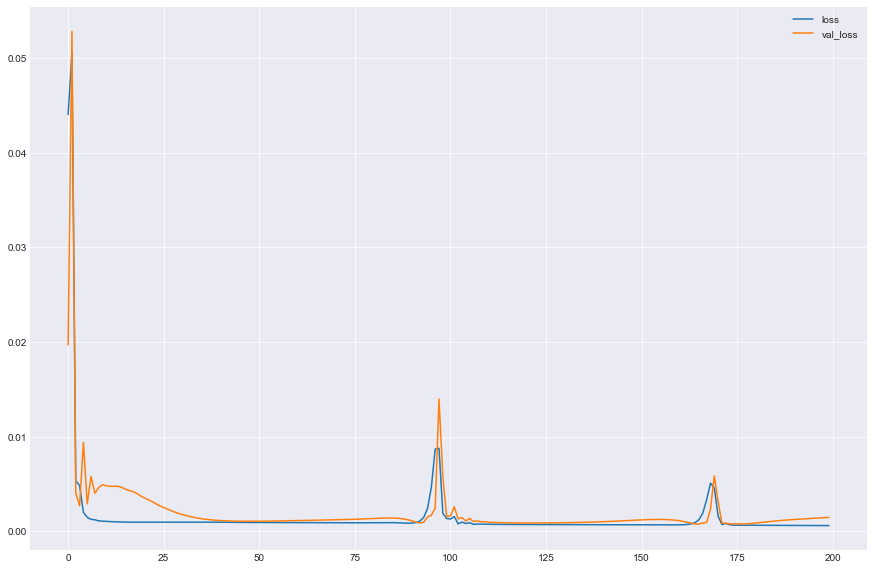

In [29]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [30]:
# make a prediction
inv_yhat = model.predict(test_X)
# inverse reshape of test_X array
test_X = test_X.reshape((test_X.shape[0], sequence))

# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, :], inv_yhat), axis=1)
inv_yhat = mm.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, :], test_y), axis=1)
inv_y = mm.inverse_transform(inv_y)
inv_y = inv_y[:,-1]



In [31]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.930


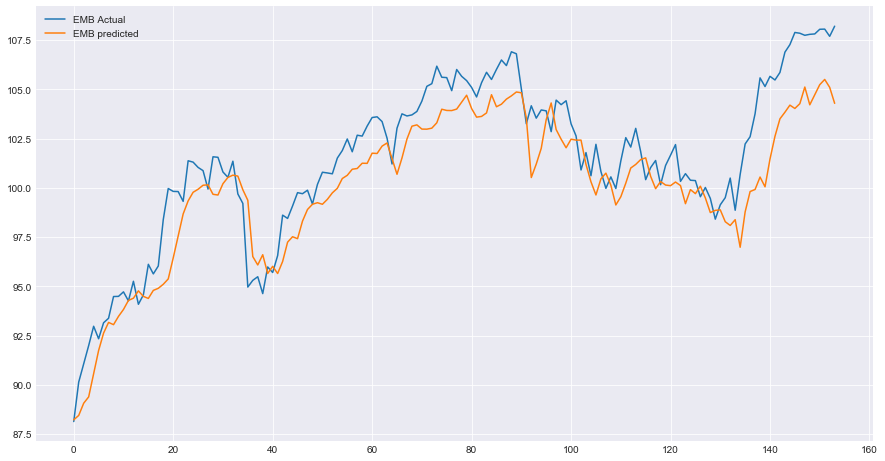

In [32]:
# Plot actual v. predicted
plt.figure(figsize=(15, 8))
plt.plot(inv_y, label='EMB Actual')
plt.plot(inv_yhat, label='EMB predicted')
plt.legend()
plt.show()

In [33]:
LSTM_multi_pred_EMB = pd.DataFrame(inv_yhat)
%store LSTM_multi_pred_EMB

Stored 'LSTM_multi_pred_EMB' (DataFrame)
